In [ ]:
load("ProcessData.RData")
library(jsonlite)
library(purrr)


Figure 1: We trust the data
- Mutational spectra
-nPCA?
All vs normal vs male

- Coverage + base quality
- Percentage of genome covered
- VAF (overall, and by mutation type?)

- Biological age-effect of SNVs


Part 1: Spectra and similarity


In [13]:
# Read the matrix
matrix <- read.table(
  "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/output/SBS/snvs.SBS6.all",
  sep = "\t",
  header = TRUE,
  stringsAsFactors = FALSE,
  check.names = FALSE
)

# matrix <- read.table(
#   "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/output/SBS/snvs.SBS96.all",
#   sep = "\t",
#   header = TRUE,
#   stringsAsFactors = FALSE,
#   check.names = FALSE
# )

# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(paste(hiatt_donors, collapse = "|"),
                   colnames(matrix),
                   value = TRUE)

# Row-wise sums
matrix$`Lee-Six` <- rowSums(matrix[, lee_donors, drop = FALSE])
matrix$Hiatt <- rowSums(matrix[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix$Hiatt
spectrum2 <- matrix$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance: %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity: %.4f\n", cosine_similarity))


Cosine distance: 0.0306
Cosine similarity: 0.9694


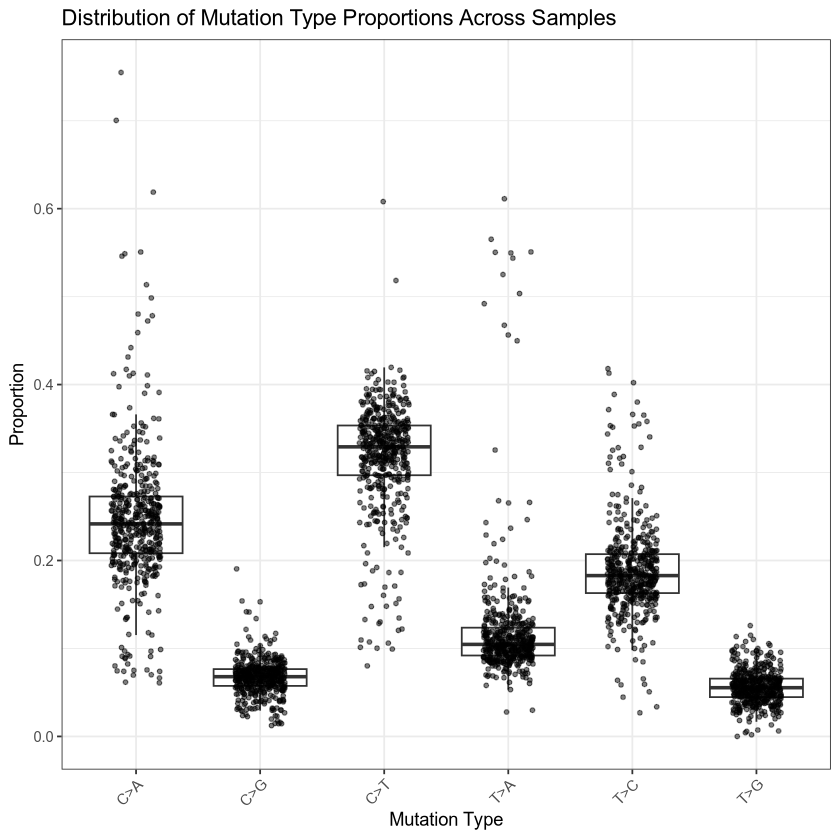

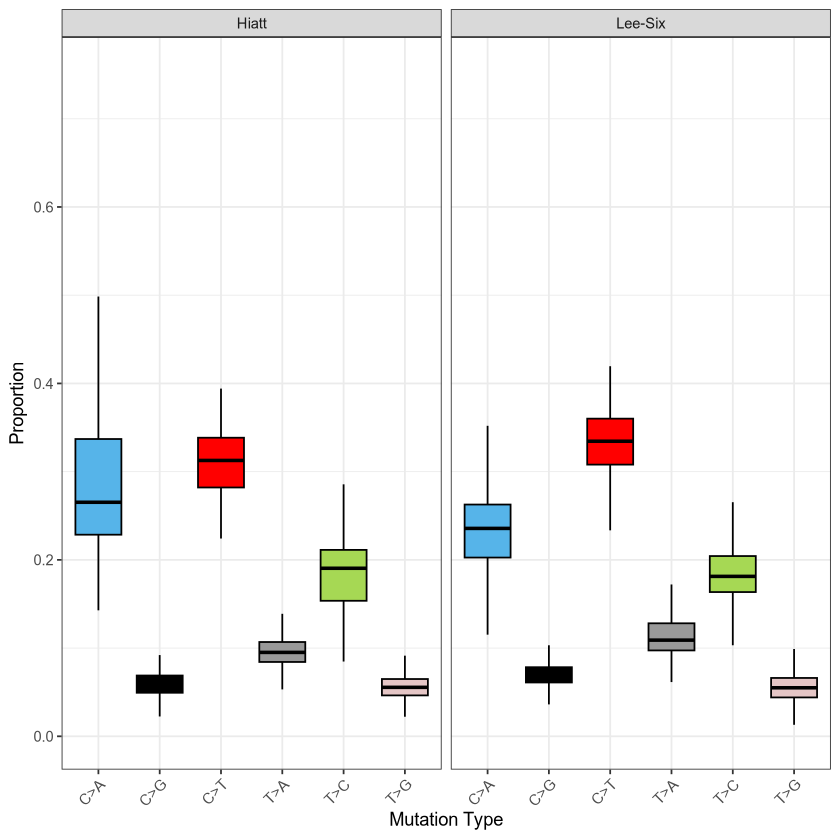

In [ ]:
# Read data
df <- matrix

# Set mutation types as rownames
rownames(df) <- df[[1]]
df <- df[, -1]

# Normalize columns to proportions
proportions <- sweep(df, 2, colSums(df), "/")

# Donor prefixes
lee_donors <- c("PD", "HLS")
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Convert to long format
df_long <- proportions %>%
  as.data.frame() %>%
  tibble::rownames_to_column("MutationType") %>%
  pivot_longer(
    cols = -MutationType,
    names_to = "Sample",
    values_to = "Proportion"
  ) %>%
  mutate(
    Cohort = case_when(
      str_starts(Sample, paste(lee_donors, collapse = "|")) ~ "Lee-Six",
      str_detect(Sample, paste(hiatt_donors, collapse = "|")) ~ "Hiatt",
      TRUE ~ "Other"
    )
  )

# ==============================
# Plot 1: Boxplot + jitter
# ==============================
ggplot(df_long, aes(x = MutationType, y = Proportion)) +
  geom_boxplot(outlier.shape = NA) +
  geom_jitter(width = 0.2, size = 1, alpha = 0.5) +
  labs(
    title = "Distribution of Mutation Type Proportions Across Samples",
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# ==============================
# Plot 2: Faceted boxplots by cohort
# ==============================
mutation_colors <- c(
  "C>A" = "#56B4E9",  # blue
  "C>G" = "#000000",  # black
  "C>T" = "#FF0000",  # red
  "T>A" = "#999999",  # gray
  "T>C" = "#A6D854",  # green
  "T>G" = "#E5C6C6"   # pink
)

df_long %>%
  filter(Cohort %in% c("Lee-Six", "Hiatt")) %>%
  ggplot(aes(
    x = MutationType,
    y = Proportion,
    fill = MutationType
  )) +
  geom_boxplot(outlier.shape = NA, color = "black") +
  facet_wrap(~ Cohort) +
  scale_fill_manual(values = mutation_colors, guide = "none") +
  labs(
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


Cosine distance (male, normal): 0.0232
Cosine similarity (male, normal): 0.9768


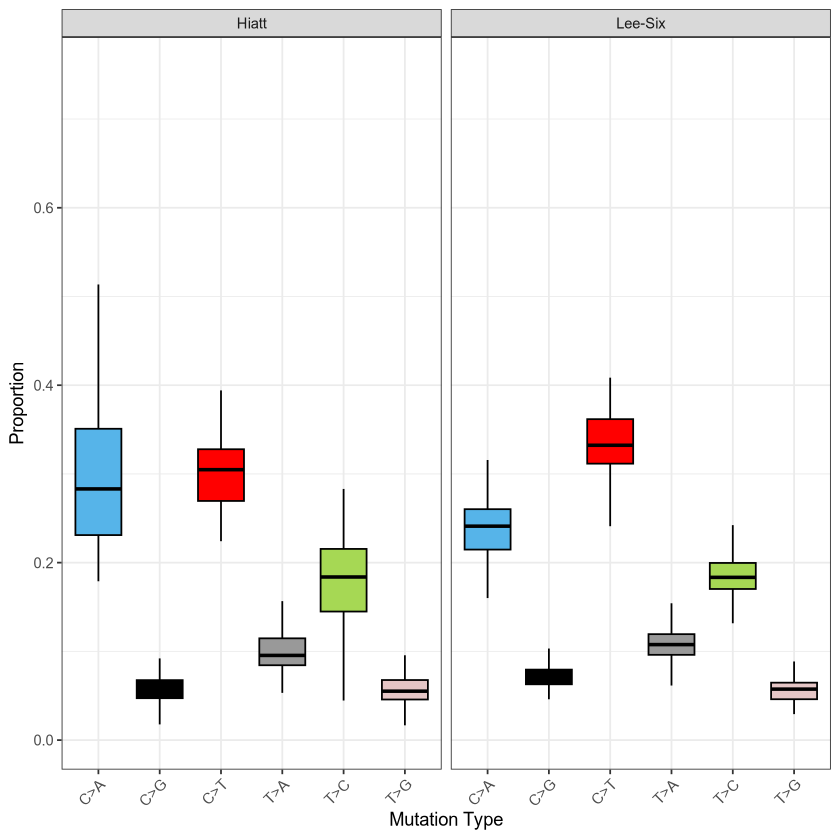

In [29]:
male_normal_crypts <- combined_df %>%
  filter(sex == "male", cohort == "normal") %>%
  pull(crypt_sample)

# Subset + plot
df_long %>%
  filter(
    Cohort %in% c("Lee-Six", "Hiatt"),
    Sample %in% male_normal_crypts
  ) %>%
  ggplot(aes(
    x = MutationType,
    y = Proportion,
    fill = MutationType
  )) +
  geom_boxplot(outlier.shape = NA, color = "black") +
  facet_wrap(~ Cohort) +
  scale_fill_manual(values = mutation_colors, guide = "none") +
  labs(
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Restrict matrix to male normal crypts only
matrix_sub <- matrix[, colnames(matrix) %in% male_normal_crypts, drop = FALSE]

# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix_sub), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(
  paste(hiatt_donors, collapse = "|"),
  colnames(matrix_sub),
  value = TRUE
)

# Row-wise sums
matrix_sub$`Lee-Six` <- rowSums(matrix_sub[, lee_donors, drop = FALSE])
matrix_sub$Hiatt <- rowSums(matrix_sub[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix_sub$Hiatt
spectrum2 <- matrix_sub$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance (male, normal): %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity (male, normal): %.4f\n", cosine_similarity))


Cosine distance (suff cov): 0.0291
Cosine similarity (suff cov): 0.9709


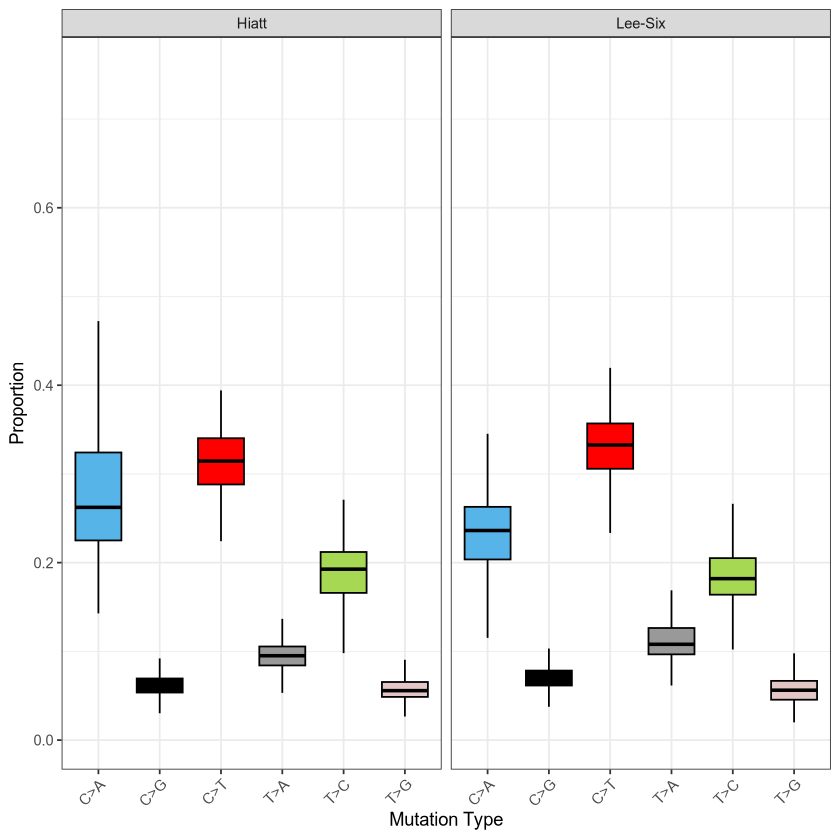

In [30]:
sufficient_cov_crypts <- combined_df %>%
  filter(coverage > 9) %>%
  pull(crypt_sample)

# Subset + plot
df_long %>%
  filter(
    Cohort %in% c("Lee-Six", "Hiatt"),
    Sample %in% sufficient_cov_crypts
  ) %>%
  ggplot(aes(
    x = MutationType,
    y = Proportion,
    fill = MutationType
  )) +
  geom_boxplot(outlier.shape = NA, color = "black") +
  facet_wrap(~ Cohort) +
  scale_fill_manual(values = mutation_colors, guide = "none") +
  labs(
    x = "Mutation Type",
    y = "Proportion"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


# Restrict matrix to male normal crypts only
matrix_sub <- matrix[, colnames(matrix) %in% sufficient_cov_crypts, drop = FALSE]

# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix_sub), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(
  paste(hiatt_donors, collapse = "|"),
  colnames(matrix_sub),
  value = TRUE
)

# Row-wise sums
matrix_sub$`Lee-Six` <- rowSums(matrix_sub[, lee_donors, drop = FALSE])
matrix_sub$Hiatt <- rowSums(matrix_sub[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix_sub$Hiatt
spectrum2 <- matrix_sub$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance (suff cov): %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity (suff cov): %.4f\n", cosine_similarity))

In [31]:
# Restrict matrix to male normal crypts only
matrix_sub <- matrix[, colnames(matrix) %in% sufficient_cov_crypts, drop = FALSE]

matrix_sub <- matrix_sub[, colnames(matrix_sub) %in% male_normal_crypts, drop = FALSE]


# Lee donors: columns containing PD or HLS
lee_donors <- grep("PD|HLS", colnames(matrix_sub), value = TRUE)

# Hiatt donors
hiatt_donors <- c("AS", "AC", "DC", "DE", "CE", "RE", "TR", "SI", "TC", "RTM", "Laurel")

# Columns matching any Hiatt donor pattern
col_hiatt <- grep(
  paste(hiatt_donors, collapse = "|"),
  colnames(matrix_sub),
  value = TRUE
)

# Row-wise sums
matrix_sub$`Lee-Six` <- rowSums(matrix_sub[, lee_donors, drop = FALSE])
matrix_sub$Hiatt <- rowSums(matrix_sub[, col_hiatt, drop = FALSE])

# Extract spectra
spectrum1 <- matrix_sub$Hiatt
spectrum2 <- matrix_sub$`Lee-Six`

# Cosine distance and similarity
cosine_distance <- 1 - sum((spectrum1 / 100) * (spectrum2 / 100)) /
  (sqrt(sum((spectrum1 / 100)^2)) * sqrt(sum((spectrum2 / 100)^2)))

cosine_similarity <- 1 - cosine_distance

# Print results
cat(sprintf("Cosine distance (suff cov): %.4f\n", cosine_distance))
cat(sprintf("Cosine similarity (suff cov): %.4f\n", cosine_similarity))

Cosine distance (suff cov): 0.0190
Cosine similarity (suff cov): 0.9810


In [ ]:
Part 2: quality and coverage

In [33]:
folder_path <- "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/reports"
json_files <- list.files(
  folder_path,
  pattern = "-fastp-report\\.json$",
  full.names = TRUE
)

rows <- lapply(json_files, function(filepath) {

  data <- fromJSON(filepath)

  q20_rate <- data$summary$before_filtering$q20_rate
  q30_rate <- data$summary$before_filtering$q30_rate

  filename <- basename(filepath)
  sample_name <- str_remove(filename, "-fastp-report\\.json$")

  group <- ifelse(
    str_detect(filename, str_c(hiatt_donors, collapse = "|")),
    "Hiatt",
    "Lee-Six"
  )

  tibble(
    sample_name = sample_name,
    group = group,
    q20_rate = q20_rate,
    q30_rate = q30_rate
  )
})

df <- bind_rows(rows)


In [34]:
summary_stats <- df %>%
  group_by(group) %>%
  summarise(
    n = n(),
    avg_q20 = mean(q20_rate, na.rm = TRUE),
    avg_q30 = mean(q30_rate, na.rm = TRUE),
    .groups = "drop"
  )

In [43]:
df_long <- df %>%
  pivot_longer(
    cols = c(q20_rate, q30_rate),
    names_to = "Quality_Metric",
    values_to = "Rate"
  )

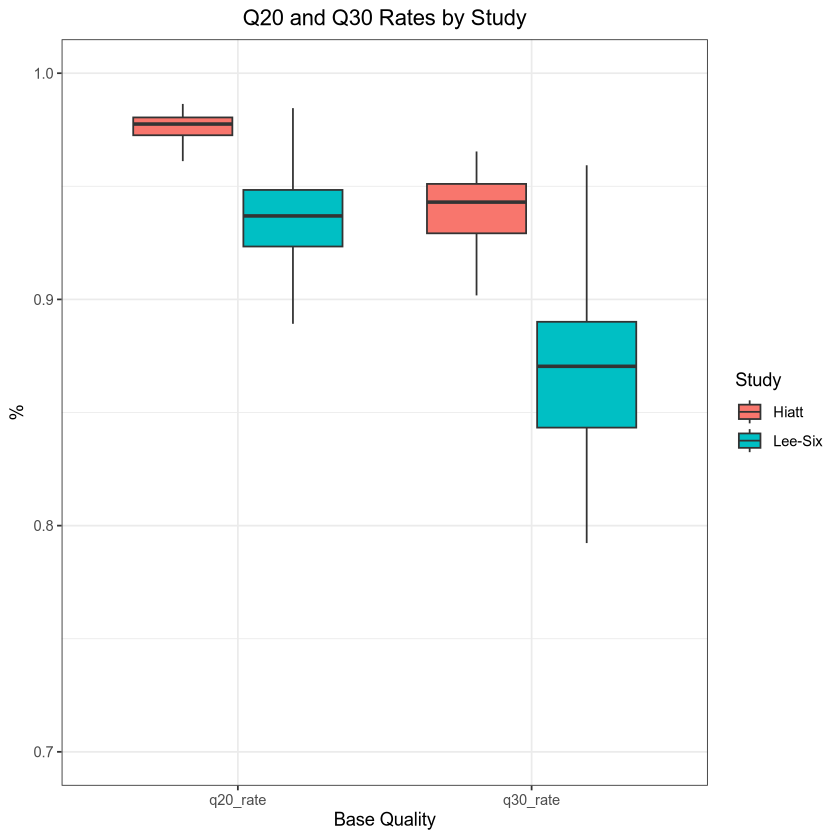

In [ ]:
p <- ggplot(df_long, aes(
  x = Quality_Metric,
  y = Rate,
  fill = group
)) +
  geom_boxplot(outlier.shape = NA) +
  coord_cartesian(ylim = c(0.7, 1.0)) +
  labs(
    title = "Q20 and Q30 Rates by Study",
    x = "Base Quality",
    y = "%",
    fill = "Study"
  ) +
  theme_bw() +
  theme(
    plot.title = element_text(hjust = 0.5)
  )

print(p)


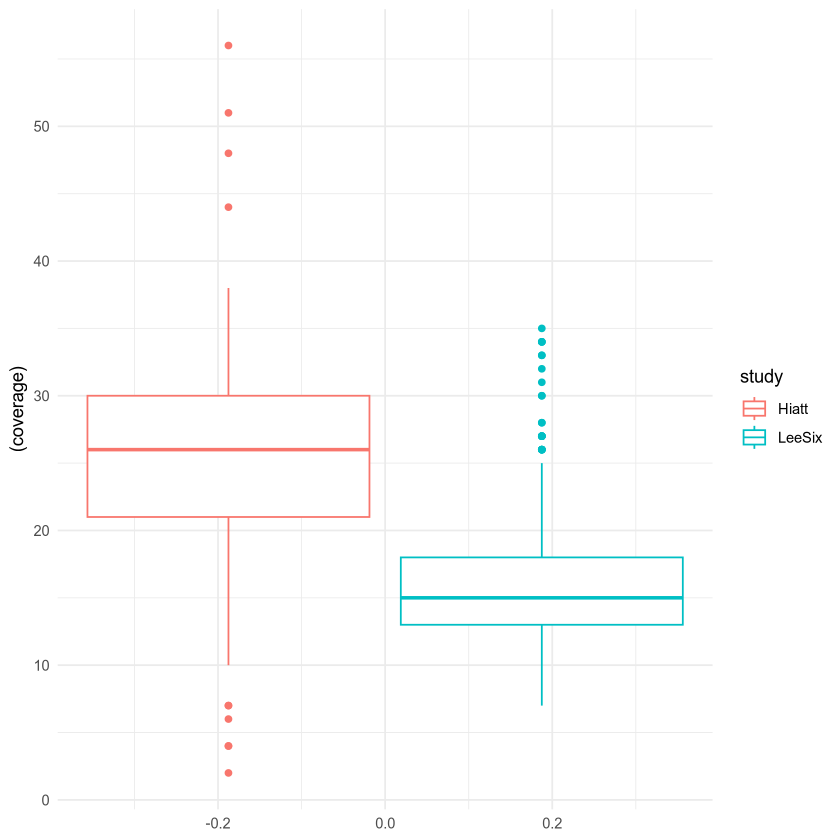

In [48]:
ggplot(combined_df) + geom_boxplot(aes(y=(coverage), color = study)) + theme_minimal()


# A tibble: 2 × 6
  study  n_samples mean_bases_covered median_bases_covered mean_fraction_covered
  <fct>      <int>              <dbl>                <dbl>                 <dbl>
1 Hiatt        124        2602084326.          2847478852.                 0.839
2 LeeSix       324        2696946697.          2790701527                  0.870
# ℹ 1 more variable: median_fraction_covered <dbl>



	Kruskal-Wallis rank sum test

data:  depth by study
Kruskal-Wallis chi-squared = 22.976, df = 1, p-value = 1.64e-06


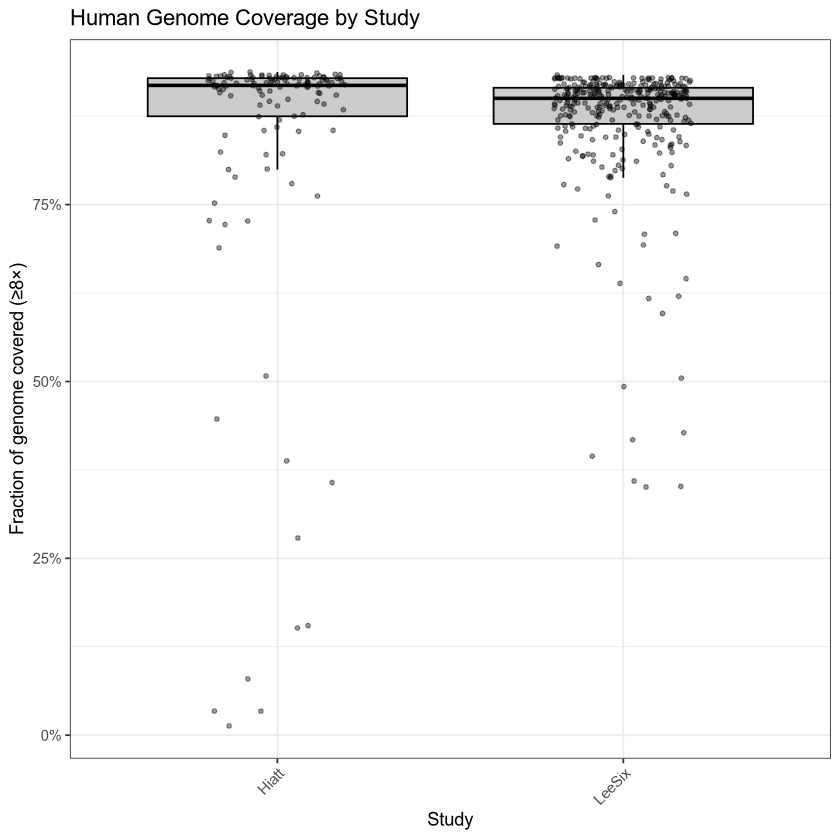

In [52]:
genome_size <- 3.1e9  # human genome (bp), adjust if needed

coverage_by_study <- combined_df %>%
  group_by(study) %>%
  summarise(
    n_samples = n(),
    mean_bases_covered = mean(depth, na.rm = TRUE),
    median_bases_covered = median(depth, na.rm = TRUE),
    mean_fraction_covered = mean(depth / genome_size, na.rm = TRUE),
    median_fraction_covered = median(depth / genome_size, na.rm = TRUE),
    .groups = "drop"
  )

print(coverage_by_study)

ggplot(combined_df, aes(
  x = study,
  y = depth / genome_size
)) +
  geom_boxplot(outlier.shape = NA, fill = "grey80", color = "black") +
  geom_jitter(width = 0.2, alpha = 0.4, size = 1) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    x = "Study",
    y = "Fraction of genome covered (≥8×)",
    title = "Human Genome Coverage by Study"
  ) +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

kruskal.test(depth ~ study, data = combined_df)



Part 3: VAF

In [56]:
input_dir <- "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/txtfiles_all/snvs"
out_png <- "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/figures/plots"

dir.create(out_png, recursive = TRUE, showWarnings = FALSE)

txt_files <- list.files(input_dir, pattern = "\\.snvs_merged\\.tsv$", full.names = TRUE)


In [63]:
mutation_map <- list(
  "C>A" = c("C>A", "G>T"),
  "C>G" = c("C>G", "G>C"),
  "C>T" = c("C>T", "G>A"),
  "T>A" = c("T>A", "A>T"),
  "T>C" = c("T>C", "A>G"),
  "T>G" = c("T>G", "A>C")
)

assign_class <- function(ref, alt) {

  ref <- toupper(ref)
  alt <- toupper(alt)

  if (nchar(ref) != 1 || nchar(alt) != 1 || ref == alt)
    return(NA)

  mut <- paste0(ref, ">", alt)

  if (mut %in% c("C>A", "G>T")) return("C>A")
  if (mut %in% c("C>G", "G>C")) return("C>G")
  if (mut %in% c("C>T", "G>A")) return("C>T")
  if (mut %in% c("T>A", "A>T")) return("T>A")
  if (mut %in% c("T>C", "A>G")) return("T>C")
  if (mut %in% c("T>G", "A>C")) return("T>G")

  NA
}



In [59]:
walk(txt_files, function(f) {

  df <- read.table(f, sep = "\t", header = TRUE, comment.char = "#")
  if (!"VAF_DS" %in% colnames(df)) return()

  sample <- str_remove(basename(f), "\\.snvs_merged\\.tsv$")

  p <- ggplot(df, aes(VAF_DS)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    coord_cartesian(xlim = c(0, 1)) +
    labs(
      title = paste(sample, "- Unique SNV VAFs"),
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    theme_bw()

  ggsave(
    file.path(out_png, paste0(sample, "_vaf_hist.png")),
    p, dpi = 300, width = 8, height = 3
  )
})


In [66]:
plot_vaf_by_class <- function(txt_file, out_dir) {

  df <- read.table(txt_file, sep = "\t", header = TRUE, comment.char = "#")
  sample <- str_remove(basename(txt_file), "\\.snvs_merged\\.tsv$")

  # 🔑 Normalize REF + ALT BEFORE classification
  df$REF_base <- substr(toupper(df$REF), 1, 1)
  df$ALT_base <- toupper(df$ALT)

  # Assign SBS6 class (CpG → C, GpC → G, etc.)
  df$Class <- mapply(assign_class, df$REF_base, df$ALT_base)

  # (Optional but strongly recommended sanity check)
  if (any(is.na(df$Class))) {
    warning(
      sprintf(
        "Unclassified mutations in %s:\n%s",
        sample,
        paste(unique(paste(df$REF, df$ALT)[is.na(df$Class)]), collapse = ", ")
      )
    )
  }

  p <- ggplot(df, aes(VAF_DS)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    facet_wrap(~ Class, nrow = 2) +
    coord_cartesian(xlim = c(0, 1)) +
    labs(
      title = paste(sample, "- VAF by Mutation Type"),
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    theme_bw()

  ggsave(
    file.path(out_dir, paste0(sample, "_mutation_classes.png")),
    p, dpi = 300, width = 15, height = 8
  )
}


walk(txt_files, plot_vaf_by_class, out_dir = out_png)


In [70]:
read_and_classify <- function(files, tags) {
  map_dfr(files, function(f) {

    if (!any(str_detect(basename(f), tags))) return(NULL)

    df <- read.table(f, sep = "\t", header = TRUE, comment.char = "#")

    df$REF_base <- substr(toupper(df$REF), 1, 1)
    df$ALT_base <- toupper(df$ALT)

    df$Class <- mapply(assign_class, df$REF_base, df$ALT_base)

    df
  })
}


lee_df <- read_and_classify(txt_files, lee_donors)
hiatt_df <- read_and_classify(txt_files, hiatt_donors)


In [72]:
plot_vaf_by_class_donors <- function(df, cohort_name, out_dir) {

  p <- ggplot(df, aes(VAF_DS)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black") +
    facet_wrap(~ Class, nrow = 2) +
    coord_cartesian(xlim = c(0, 1), ylim = c(0, 10000)) +
    labs(
      title = paste(cohort_name, "- VAF by Mutation Type"),
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    theme_bw()

  ggsave(
    file.path(out_dir, paste0(cohort_name, "_mutation_classes.png")),
    p, dpi = 300, width = 15, height = 8
  )
}

if (nrow(lee_df) > 0)
  plot_vaf_by_class_donors(lee_df, "LeeSix_cohort", out_png)

if (nrow(hiatt_df) > 0)
  plot_vaf_by_class_donors(hiatt_df, "Hiatt_cohort", out_png)


In [82]:
plot_vaf_by_class_overlay <- function(df, out_dir) {

  p <- ggplot(df, aes(x = VAF_DS, fill = Cohort)) +
    geom_histogram(
      bins = 30,
      position = "identity",
      alpha = 0.5,
      color = "black"
    ) +
    facet_wrap(~ Class, nrow = 2) +
    coord_cartesian(xlim = c(0, 1), ylim = c(0, 10000)) +
    scale_fill_manual(
      values = c(
        "Lee-Six" = "steelblue",
        "Hiatt"   = "darkorange"
      ),
      breaks = c("Lee-Six", "Hiatt"),
      labels = c("Lee-Six", "Hiatt")
    ) +
    labs(
      title = "VAF by Mutation Type: Lee-Six vs Hiatt",
      x = "Variant Allele Frequency (VAF)",
      y = "Count",
      fill = "Cohort"
    ) +
    theme_bw()

  ggsave(
    file.path(out_dir, "VAF_comparison_overlay_subtypes.png"),
    p, dpi = 300, width = 15, height = 8
  )
}


big_df <- bind_rows(
    lee_df %>% mutate(Cohort = "Lee-Six"),
    hiatt_df %>% mutate(Cohort = "Hiatt")
  )


if (nrow(big_df) > 0)
  plot_vaf_by_class_overlay(big_df, out_png)


In [81]:
plot_vaf_overlay <- function(lee_df, hiatt_df, out_dir) {

  df <- bind_rows(
    lee_df %>% mutate(Cohort = "Lee-Six"),
    hiatt_df %>% mutate(Cohort = "Hiatt")
  )

  p <- ggplot(df, aes(VAF_DS, fill = Cohort)) +
    geom_histogram(
      bins = 30, position = "identity", alpha = 0.5, color = "black"
    ) +
    coord_cartesian(xlim = c(0, 1)) +
    labs(
      title = "VAF Comparison: Lee-Six vs Hiatt (Overlay)",
      x = "Variant Allele Frequency (VAF)",
      y = "Count"
    ) +
    scale_fill_manual(values = c("Lee-Six" = "steelblue", "Hiatt" = "darkorange")) +
    theme_bw()

  ggsave(
    file.path(out_dir, "VAF_comparison_overlay_overall.png"),
    p, dpi = 300, width = 10, height = 6
  )
}

if (nrow(hiatt_df) > 0)
  plot_vaf_overlay(lee_df, hiatt_df, out_png)
